# Hypothesis testing

This notebook provides demo on various hypothesis testing, in Python code. The data are borrowed from [An Introduction to Statistical Learning](http://faculty.marshall.usc.edu/gareth-james/ISL/). 

This is merely for practice, so please do not re-use it for commercial purposes.

In [1]:
import os
# Scientific libraries
import numpy as np
import pandas as pd

# Graphic libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='talk')

# Creating alias for magic commands
%alias_magic t time

#tools for modeling
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

Created `%t` as an alias for `%time`.
Created `%%t` as an alias for `%%time`.


In [56]:
# Stats
from scipy import stats
from scipy.stats import norm

In [5]:
car_data = pd.read_csv('data/Auto.csv')
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           397 non-null    float64
 1   cylinders     397 non-null    int64  
 2   displacement  397 non-null    float64
 3   horsepower    397 non-null    object 
 4   weight        397 non-null    int64  
 5   acceleration  397 non-null    float64
 6   year          397 non-null    int64  
 7   origin        397 non-null    int64  
 8   name          397 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.0+ KB


In [6]:
car_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [7]:
car_data.describe()

,mpg,cylinders,displacement,weight,acceleration,year,origin
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,23.515869,5.458438,193.532746,2970.261965,15.555668,75.994962,1.574307
std,7.825804,1.701577,104.379583,847.904119,2.749995,3.690005,0.802549
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.000000,2223.000000,13.800000,73.000000,1.000000
50%,23.000000,4.000000,146.000000,2800.000000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3609.000000,17.100000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [17]:
type(car_data.horsepower.values[0])

str

In [18]:
# why horsepower dtype is object? there should be some non-numeric value in the column
# a simple value_counts not work, as there are too many values
idx = [i for i, v in enumerate(car_data.horsepower.values) if not str.isnumeric(v)]
car_data.iloc[idx]['horsepower']

32     ?
126    ?
330    ?
336    ?
354    ?
Name: horsepower, dtype: object

In [ ]:
# convert to float, replace ? by NA
car_data.horsepower = car_data.horsepower.apply(lambda s: float(s) if str.isnumeric(s) else np.nan)

In [83]:
# drop NAs
car_data.dropna(subset=['horsepower'], inplace=True)

In [21]:
print(list(car_data))

['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']


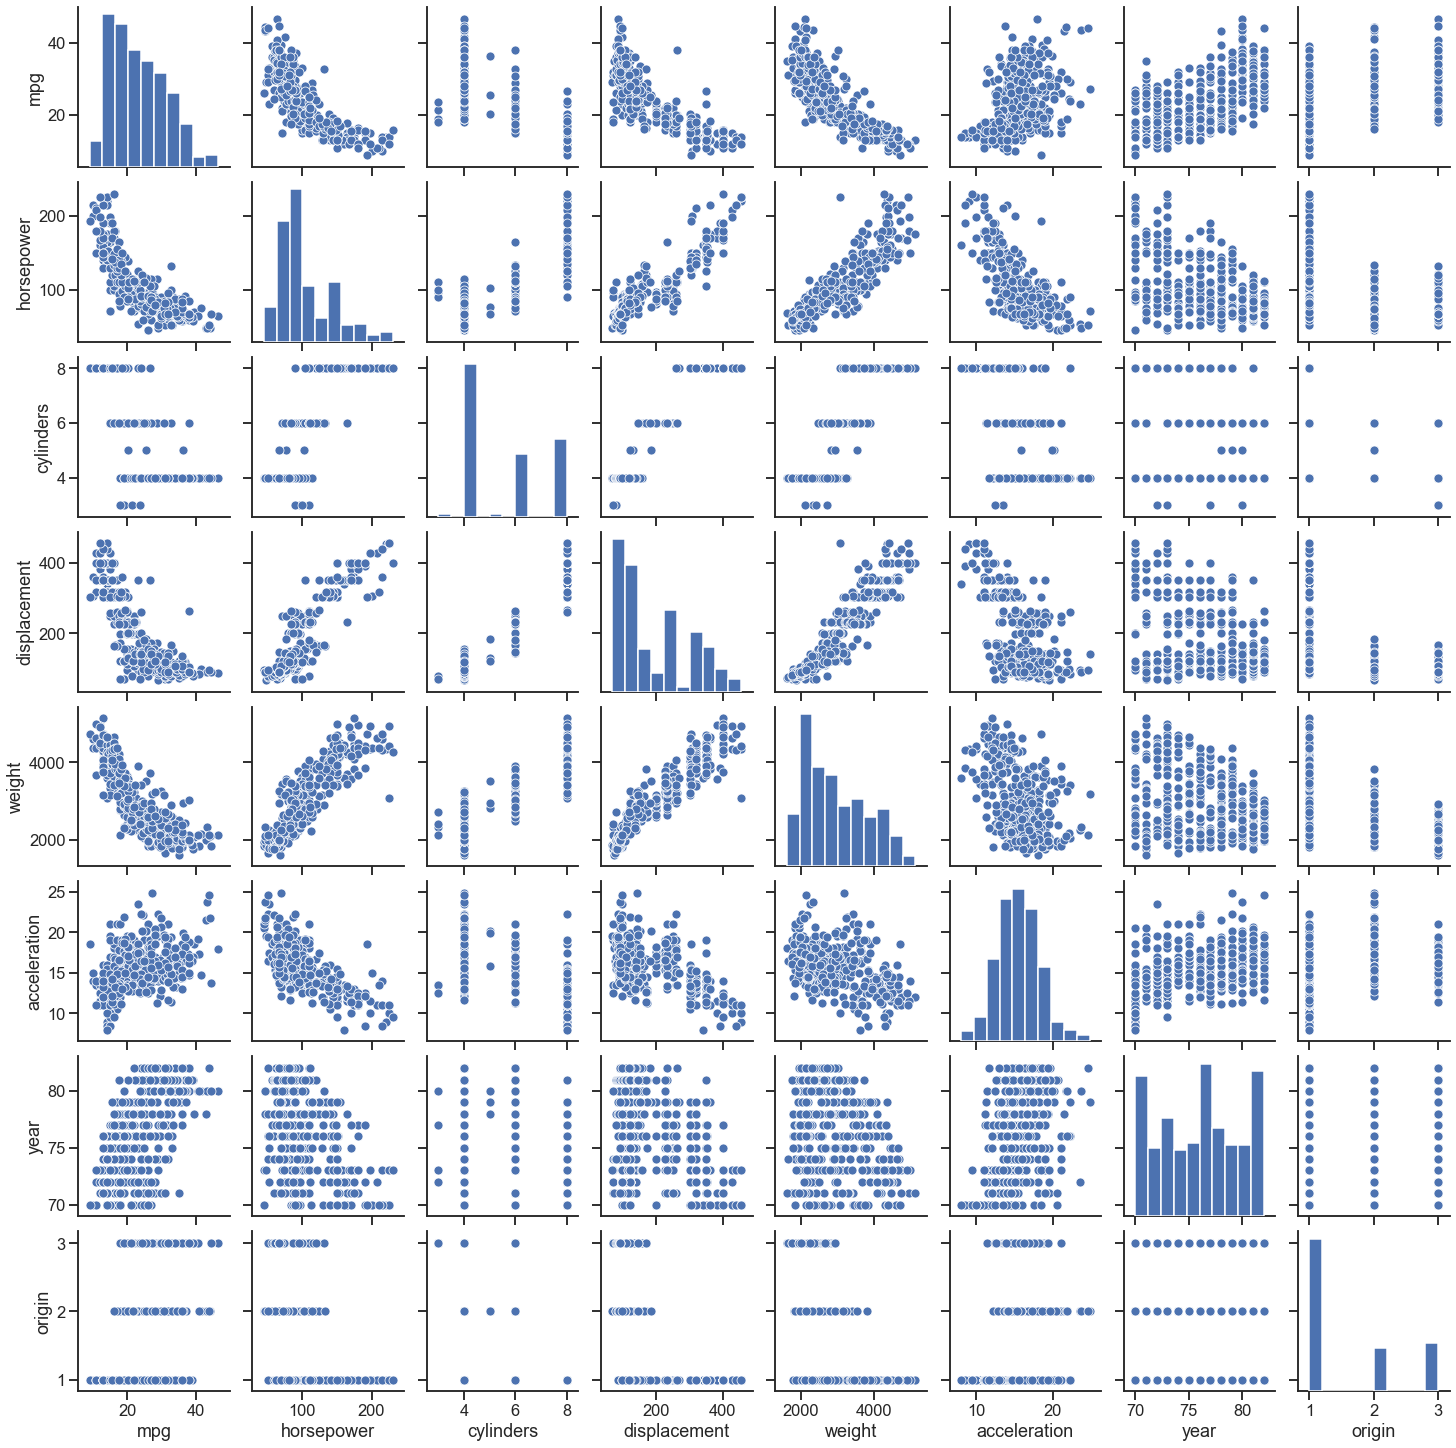

In [22]:
# reorder columns to easily see relationship between mileage and horsepower on remaining vars
cols = ['mpg', 'horsepower', 'cylinders', 'displacement', 'weight', 'acceleration', 'year', 'origin']
sns.pairplot(car_data[cols])

__Obs:__

+ clear linear trends for pairs (mpg, horsepower), (horsepower, displacement), (horsepower, weight)
+ mpg were clearly separated by three groups of origins (US, Euro and Japan)

## Comparing means of populations - Unknown variance

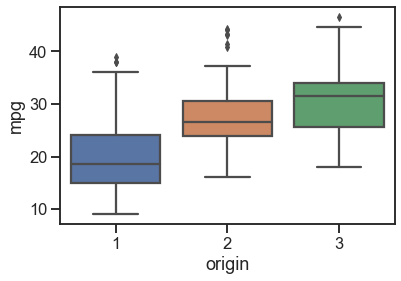

In [24]:
bp = sns.boxplot(x='origin', y='mpg', data=car_data)

The box plot shows clear difference in `mpg` among cars manufactured in US, Euro and Japan. But I still perform hypothesis testing, for the sake of practice.

In [26]:
def to_origin_name(x):
    return {1: 'US', 2: 'EURO', 3: 'JAPAN'}[x]
    
car_data['origin_name'] = car_data['origin'].apply(to_origin_name)
car_data.origin_name.value_counts()

US       248
JAPAN     79
EURO      70
Name: origin_name, dtype: int64

As the samples are large, we can use z-test.

In [35]:
grouped = car_data.groupby('origin_name').agg({'mpg': [len, np.mean, np.var, np.std]}) #.reset_index()
grouped

mpg                                
               len       mean        var       std
origin_name                                       
EURO          70.0  27.891429  45.211230  6.723930
JAPAN         79.0  30.450633  37.088685  6.090048
US           248.0  20.071774  41.128431  6.413145

In [30]:
grouped.loc['US']['mpg']['len']

mpg                      
               len       mean        var
origin_name                             
EURO          70.0  27.891429  45.211230
JAPAN         79.0  30.450633  37.088685
US           248.0  20.071774  41.128431

In [46]:
def lookup_critical_value(alpha, cl=None, test='z-test'):
    # conf. lvl. not given, instead alpha is given
    if not cl:
        cl = 1 - alpha 
    
    p_cum = cl + (1 - cl)/2
    if test=='z-test':
        critical_value = stats.norm.ppf(p_cum)
    else: # t-test
        critical_value = stats.t.ppf(p_cum) # change this to include dof
    
    return critical_value

__(H0):__ mean mpgs of US and Euro cars are not different

In [48]:
alpha = 0.05
n_us, n_euro = grouped.loc['US']['mpg']['len'], grouped.loc['EURO']['mpg']['len']
mu_us, mu_euro = grouped.loc['US']['mpg']['mean'], grouped.loc['EURO']['mpg']['mean']
std_us, std_euro = grouped.loc['US']['mpg']['std'], grouped.loc['EURO']['mpg']['std']

# use formula for SE when variance unknown
se = np.sqrt(std_us**2/n_us + std_euro**2/n_euro)

# z-score
z_score = (mu_us - mu_euro)/se
print(z_score)

abs(z_score) > lookup_critical_value(alpha=alpha)

-8.679320580877828


True

As shown, the difference between mean mpgs of cars from US and EURO is in extreme region far below $0$, so we reject (H0).

In [52]:
# p-value
print(2*stats.norm().cdf(z_score))

3.981400044951349e-18


The p-value is extremely small, thus the null hypothesis is unlikely to generate observations in our data, so we reject null hypo.

In [53]:
# 95% CI for the difference between US and Euro cars
dhat = mu_us - mu_euro
# dhat - abs(z_score)*se, dhat + abs(z_score)*se
stats.norm(loc=dhat, scale=se).interval(1-alpha)

(-9.585488559182668, -6.053820196577714)

So, we can say with 95% confidence level that, on avg gas mileage of US cars is less than gas mileage of EURO by an amount from 6 miles to even 9.5 miles.

In [54]:
# 95% CI for the mileage difference between US and Japan cars
mu_japan, std_japan = grouped.loc['JAPAN']['mpg']['mean'], grouped.loc['JAPAN']['mpg']['std']
n_japan = grouped.loc['JAPAN']['mpg']['len']
se_us_japan = np.sqrt(std_us**2/n_us + std_japan**2/n_japan)
stats.norm(loc=mu_us - mu_japan, scale=se_us_japan).interval(1 - alpha)

(-11.941083391747053, -8.816634043940976)

## Test on normality

To check if `mpg` (per origin) follows normal distribution.


 mu = 20.07 and sigma = 6.40



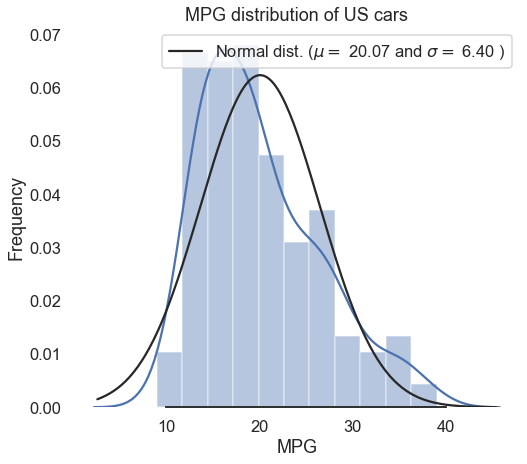

In [58]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))

x = car_data[car_data.origin_name=='US']['mpg']
#Check the new distribution
sns.distplot(x , fit=norm, color="b");
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(x)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu,sigma)],
    loc='best')
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="MPG")
ax.set(title="MPG distribution of US cars")
sns.despine(trim=True, left=True)
plt.show()

In [66]:
ts, pvalue = stats.skewtest(x)
print ('skewtest teststat = {}, pvalue = {}'.format(ts, pvalue))

skewtest teststat = 4.827005374892909, pvalue = 1.3860138233525616e-06


In [67]:
ts, pvalue = stats.kurtosistest(x)
print ('kurtosistest teststat = {}, pvalue = {}'.format(ts, pvalue))

kurtosistest teststat = 0.37686355873028443, pvalue = 0.7062750040043972


In [65]:
ts, pvalue = stats.normaltest(x)
print ('normaltest teststat = {}, pvalue = {}'.format(ts, pvalue))

normaltest teststat = 23.44200703114389, pvalue = 8.121436459378808e-06


As pvalue of normality test is very small, we can reject null hypothesis that `mpg` of US cars follow normal distribution.

## Goodness of fit

The target variable will be gas mileage `mpg`. As the target has linear trends with horsepower, displacement and weight, I will inspect goodness of fitting target with predictors incrementally. So I will perform linear regression incrementally.

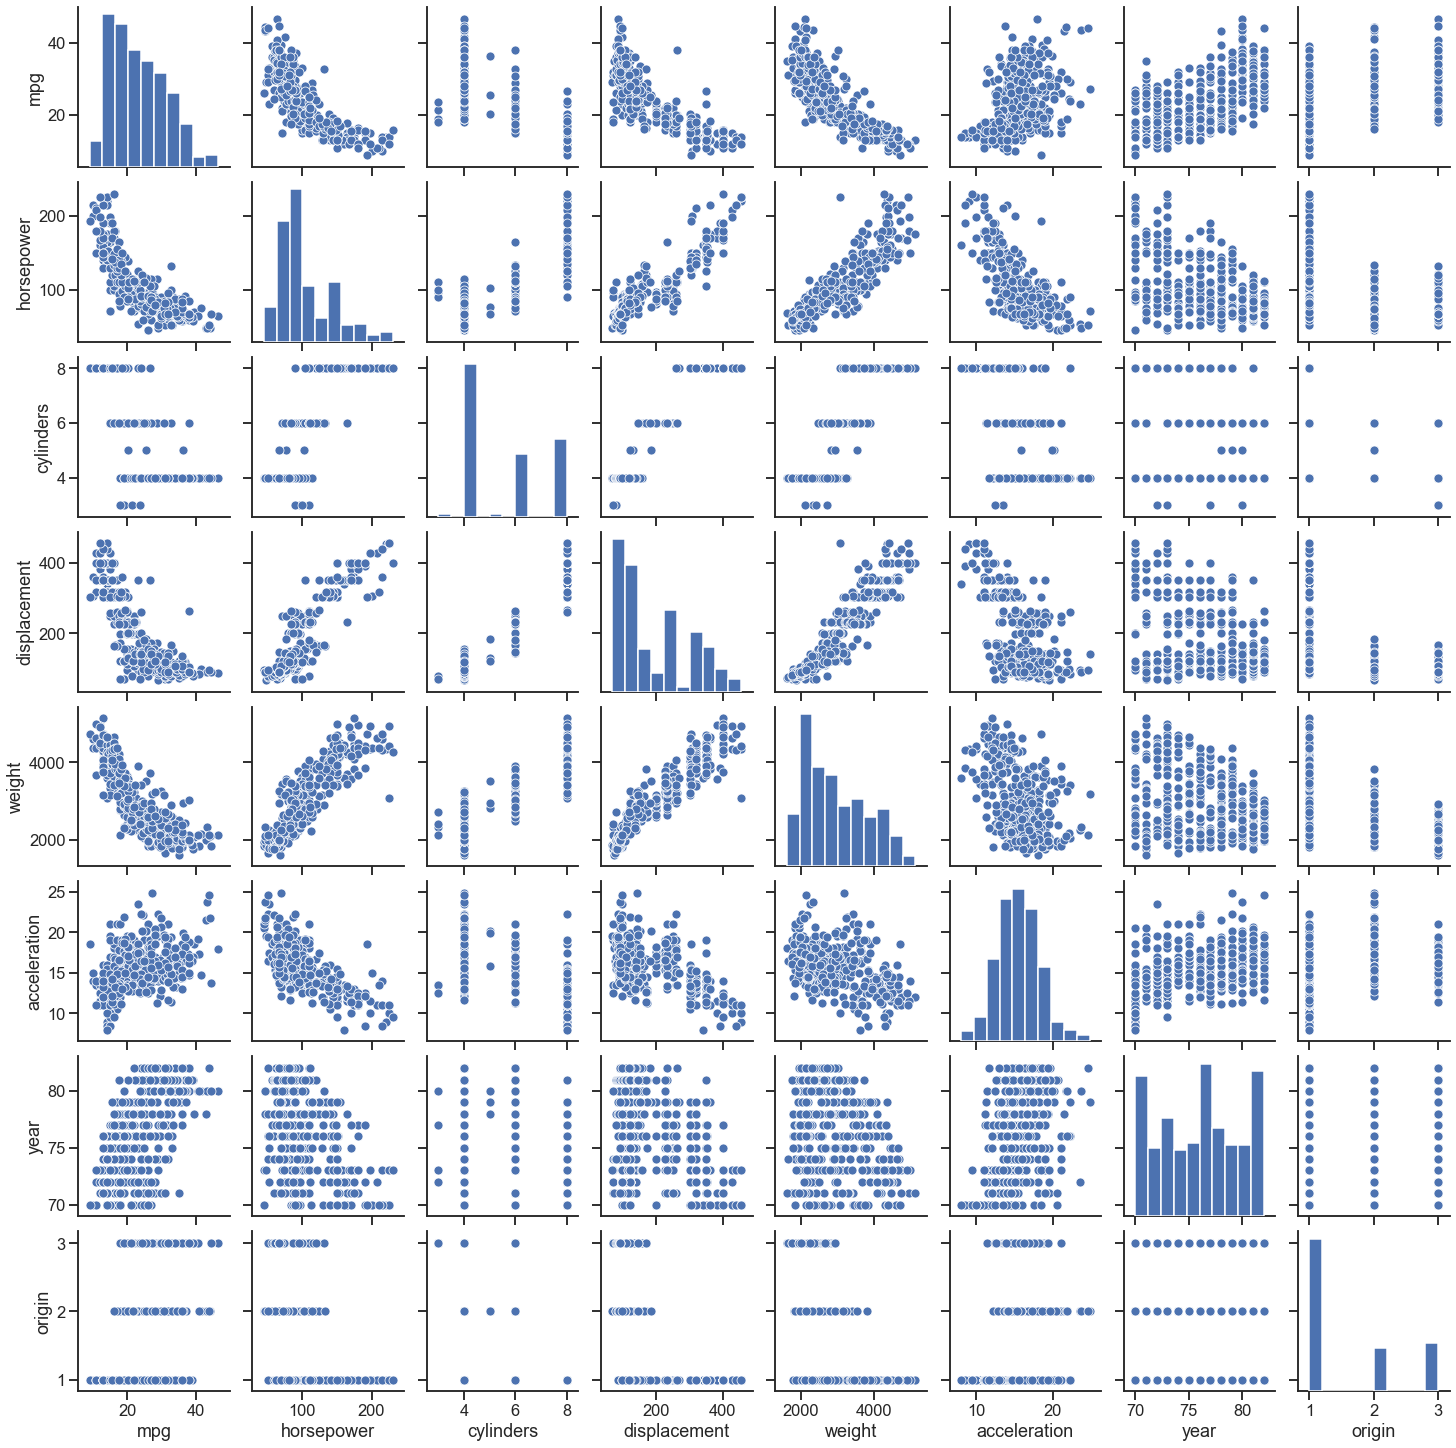

In [22]:
# reorder columns to easily see relationship between mileage and horsepower on remaining vars
cols = ['mpg', 'horsepower', 'cylinders', 'displacement', 'weight', 'acceleration', 'year', 'origin']
sns.pairplot(car_data[cols])

### Fit on `weight` only

In [92]:
X=np.reshape(car_data['weight'].values , (-1, 1))
y=np.reshape(car_data['mpg'].values , (-1, 1))

In [93]:
# via sklearn linear model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)
r2 = lr.score(X, y)
print('R^2:', round(r2, 3))

R^2: 0.693


In [94]:
# more comprehensive via statsmodels
import statsmodels.api as sm
model = sm.OLS(car_data['mpg'], car_data['weight'], missing='drop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.707
Model:                            OLS   Adj. R-squared (uncentered):              0.706
Method:                 Least Squares   F-statistic:                              942.2
Date:                Mon, 13 Jul 2020   Prob (F-statistic):                   3.40e-106
Time:                        10:16:52   Log-Likelihood:                         -1573.0
No. Observations:                 392   AIC:                                      3148.
Df Residuals:                     391   BIC:                                      3152.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
weight         0.0067      0.000     30.696      0.000       0.006       0.007
==============================================================================
Omnibus:                       61.704   Durbin-Watson:                   0.480
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               15.054
Skew:                          -0.039   Prob(JB):                     0.000538
Kurtosis:                       2.043   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2 = 0.70$, which means this fit explains 70% of variance.

### Add `horsepower`

In [95]:
model = sm.OLS(car_data['mpg'], car_data[['weight', 'horsepower']], 
               missing='drop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.722
Model:                            OLS   Adj. R-squared (uncentered):              0.721
Method:                 Least Squares   F-statistic:                              506.5
Date:                Mon, 13 Jul 2020   Prob (F-statistic):                   3.79e-109
Time:                        10:17:44   Log-Likelihood:                         -1562.5
No. Observations:                 392   AIC:                                      3129.
Df Residuals:                     390   BIC:                                      3137.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
horsepower    -0.1559      0.034     -4.634      0.000      -0.222      -0.090
weight         0.0122      0.001     10.108      0.000       0.010       0.015
==============================================================================
Omnibus:                       80.488   Durbin-Watson:                   0.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.761
Skew:                          -0.021   Prob(JB):                     0.000229
Kurtosis:                       1.988   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2 = 0.72$, so adding `horsepower` explains $2\%$ more.

### Add `displacement`

This feature is engine displacement.

In [96]:
model = sm.OLS(car_data['mpg'], 
               car_data[[ 'weight', 'horsepower', 'displacement']], 
               missing='drop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    mpg   R-squared (uncentered):                   0.865
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              831.4
Date:                Mon, 13 Jul 2020   Prob (F-statistic):                   9.31e-169
Time:                        10:22:22   Log-Likelihood:                         -1420.8
No. Observations:                 392   AIC:                                      2848.
Df Residuals:                     389   BIC:                                      2860.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
weight           0.0166      0.001     19.074      0.000       0.015       0.018
horsepower       0.0916      0.026      3.463      0.001       0.040       0.144
displacement    -0.1905      0.009    -20.308      0.000      -0.209      -0.172
==============================================================================
Omnibus:                        3.555   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                4.132
Skew:                          -0.044   Prob(JB):                        0.127
Kurtosis:                       3.495   Cond. No.                         181.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Big boost, $R^2 = 0.865$, so adding `displacement` explains $14\%$ more of variance :)